In [121]:
## importing all needed packages

import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import time
import warnings
from statsmodels.imputation import mice
warnings.filterwarnings('ignore')

from matplotlib import rcParams
import cufflinks as cf

import plotly.offline as py 
import plotly.figure_factory as ff 
import plotly.graph_objs as go 

from plotly import tools 
import plotly.express as px

#To plot figs on jupyter
%matplotlib inline
# figure size in inches
rcParams['figure.figsize'] = 16,8

In [122]:
# read dataset
df = pd.read_csv("loans_full_schema.csv", index_col=0)
df.head()

,emp_length,state,homeownership,annual_income,verified_income,debt_to_income,annual_income_joint,verification_income_joint,debt_to_income_joint,delinq_2y,...,sub_grade,issue_month,loan_status,initial_listing_status,disbursement_method,balance,paid_total,paid_principal,paid_interest,paid_late_fees
emp_title,,,,,,,,,,,,,,,,,,,,,
global config engineer,3.0,NJ,MORTGAGE,90000.0,Verified,18.01,NaN,NaN,NaN,0,...,C3,Mar-2018,Current,whole,Cash,27015.86,1999.33,984.14,1015.19,0.0
warehouse office clerk,10.0,HI,RENT,40000.0,Not Verified,5.04,NaN,NaN,NaN,0,...,C1,Feb-2018,Current,whole,Cash,4651.37,499.12,348.63,150.49,0.0
assembly,3.0,WI,RENT,40000.0,Source Verified,21.15,NaN,NaN,NaN,0,...,D1,Feb-2018,Current,fractional,Cash,1824.63,281.80,175.37,106.43,0.0
customer service,1.0,PA,RENT,30000.0,Not Verified,10.16,NaN,NaN,NaN,0,...,A3,Jan-2018,Current,whole,Cash,18853.26,3312.89,2746.74,566.15,0.0
security supervisor,10.0,CA,RENT,35000.0,Verified,57.96,57000.0,Verified,37.66,0,...,C3,Mar-2018,Current,whole,Cash,21430.15,2324.65,1569.85,754.80,0.0


Text(0.5, 1.0, 'Frequency Distribuition')

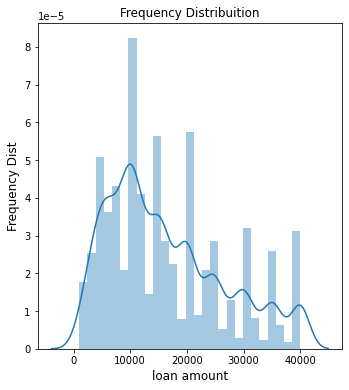

In [144]:
# We will look at loan_amount 
plt.figure(figsize=(12,6))

plt.subplot(121)
g = sns.distplot(df["loan_amount"])
g.set_xlabel("loan amount", fontsize=12)
g.set_ylabel("Frequency Dist", fontsize=12)
g.set_title("Frequency Distribuition")


-  This clearly looks like it is right skewed which means more number of number of loans are small ticket size as compared to big ticket sized loans.

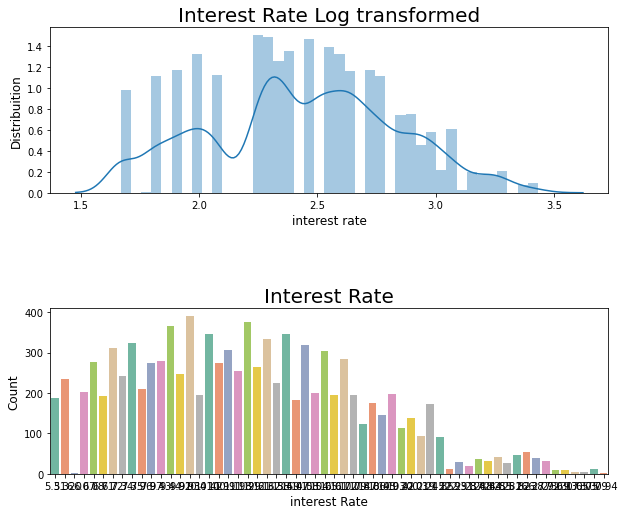

In [124]:
# next we will look at the dependent variable i.e interest rate

plt.figure(figsize = (10,8))


plt.subplot(211)
g = sns.distplot(np.log(df["interest_rate"]))
g.set_xlabel("interest rate", fontsize=12)
g.set_ylabel("Distribuition", fontsize=12)
g.set_title("Interest Rate Log transformed", fontsize=20)

plt.subplot(212)
g1 = sns.countplot(x="interest_rate",data=df, 
                   palette="Set2")
g1.set_xlabel("interest Rate", fontsize=12)
g1.set_ylabel("Count", fontsize=12)
g1.set_title("Interest Rate", fontsize=20)

plt.subplots_adjust(wspace = 0.5, hspace = 0.7,top = 0.9)

- The interest rate is right skewed and can be fixed by taking the log can shown above. It doesnt look like a bell curve but its better than the original form.

Current               9375
Fully Paid             447
In Grace Period         67
Late (31-120 days)      66
Late (16-30 days)       38
Charged Off              7
Name: loan_status, dtype: int64


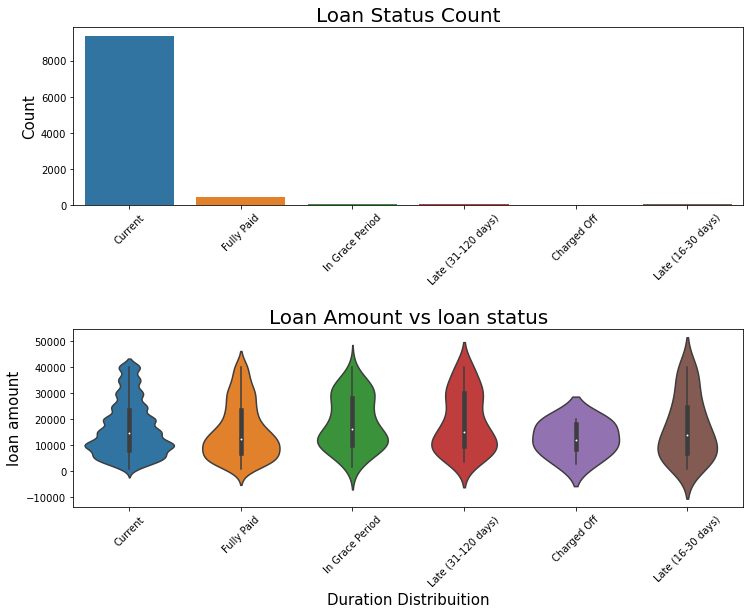

In [125]:
### Now we will look at the loan status variable

print(df.loan_status.value_counts())

plt.figure(figsize = (12,14))

plt.subplot(311)
g = sns.countplot(x="loan_status", data=df)
g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_xlabel("", fontsize=12)
g.set_ylabel("Count", fontsize=15)
g.set_title("Loan Status Count", fontsize=20)

plt.subplot(312)
g2 = sns.violinplot(x="loan_status", y="loan_amount", data=df)
g2.set_xticklabels(g2.get_xticklabels(),rotation=45)
g2.set_xlabel("Duration Distribuition", fontsize=15)
g2.set_ylabel("loan amount", fontsize=15)
g2.set_title("Loan Amount vs loan status", fontsize=20)

plt.subplots_adjust(wspace = 0.2, hspace = 0.7,top = 0.9)

plt.show()

- The first plot is as expected. Current loans will be the maximum in this data set
- Here we can see that the loans which were not paid on time/charged off were loans with higher amounts.

In [126]:
## The issue month variable does not seem to be of any importance but we will see if there is any trend.

df['issue_month'], df['issue_year'] = df['issue_month'].str.split('-', 1).str

In [127]:
df['issue_month'].value_counts()

Mar    3617
Jan    3395
Feb    2988
Name: issue_month, dtype: int64

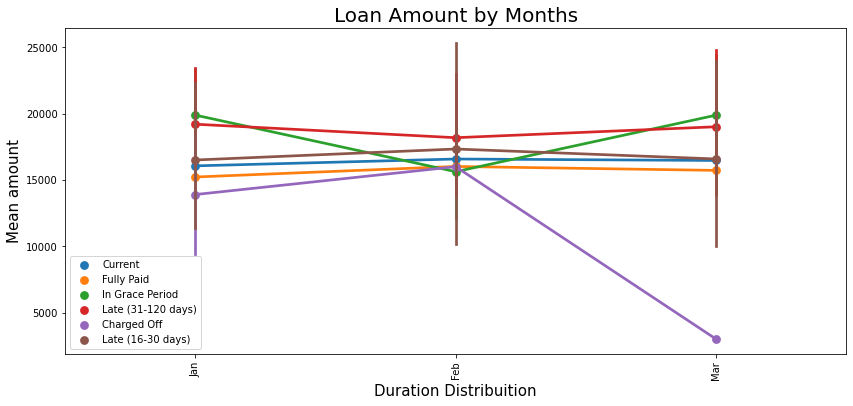

In [128]:
months_order = ["Jan", "Feb", "Mar"]
df['issue_month'] = pd.Categorical(df['issue_month'],categories=months_order, ordered=True)

#Issue_d x loan_amount
plt.figure(figsize = (14,6))

g = sns.pointplot(x='issue_month', y='loan_amount', 
                  data=df, 
                  hue='loan_status')
g.set_xticklabels(g.get_xticklabels(),rotation=90)
g.set_xlabel("Duration Distribuition", fontsize=15)
g.set_ylabel("Mean amount", fontsize=15)
g.legend(loc='best')
g.set_title("Loan Amount by Months", fontsize=20)
plt.show()

- There is no trend here

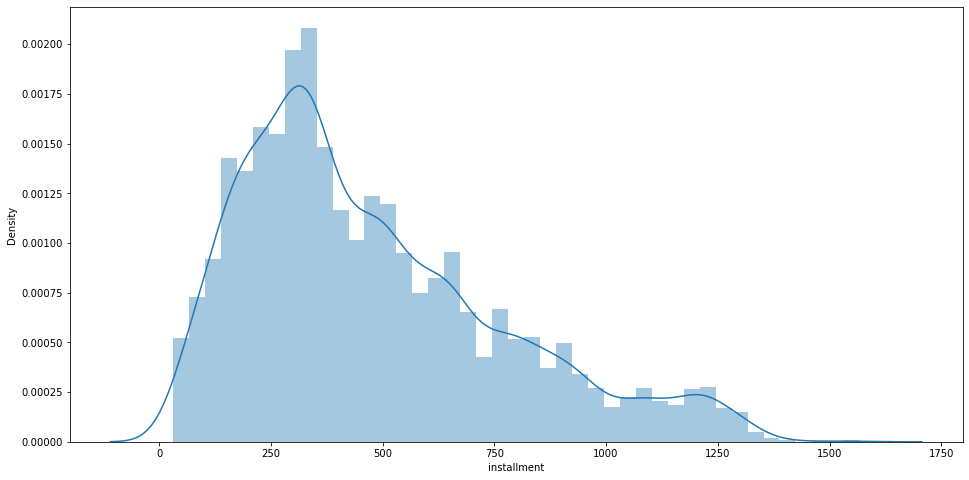

In [147]:
## Understanding the installment variable
sns.distplot(df['installment'])
plt.show()

- Most of the montly payments are less than 500 per month and this is clearly right skewed in nature.

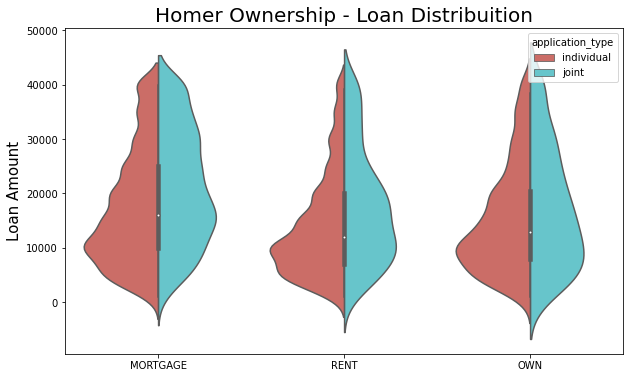

In [130]:
## Looking at home ownership by loan amount

plt.figure(figsize = (10,6))

g = sns.violinplot(x="homeownership",y="loan_amount",data=df,
               kind="violin",
               split=True,palette="hls",
               hue="application_type")
g.set_title("Homer Ownership - Loan Distribuition", fontsize=20)
g.set_xlabel("", fontsize=15)
g.set_ylabel("Loan Amount", fontsize=15)

plt.show()

- People who have a mortage have a higher loan amount.

Purposes count description: 
application_type    individual  joint
loan_purpose                         
car                        116     15
credit_card               1971    278
debt_consolidation        4289    855
home_improvement           566    114
house                      146      5
major_purchase             273     30
medical                    128     34
moving                      59     10
other                      793    121
renewable_energy             9      1
small_business             101     24
vacation                    54      8


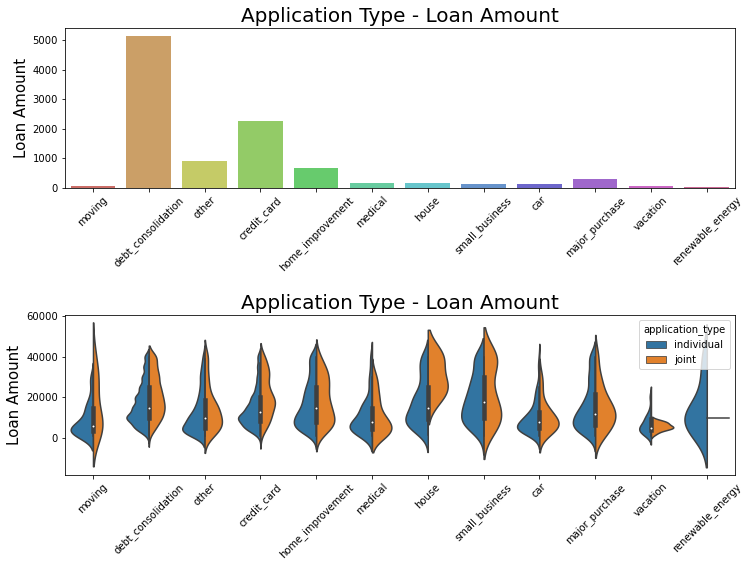

In [146]:
## now lets look at purpose variable
print("Purposes count description: ")
print(pd.crosstab(df.loan_purpose, df.application_type))

plt.figure(figsize = (12,8))

plt.subplot(211)
g = sns.countplot(x="loan_purpose",data=df,
                  palette='hls')
g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_title("Application Type - Loan Amount", fontsize=20)
g.set_xlabel("", fontsize=15)
g.set_ylabel("Loan Amount", fontsize=15)

plt.subplot(212)
g1 = sns.violinplot(x="loan_purpose",y="loan_amount",data=df,
               hue="application_type", split=True)
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
g1.set_title("Application Type - Loan Amount", fontsize=20)
g1.set_xlabel("", fontsize=15)
g1.set_ylabel("Loan Amount", fontsize=15)

plt.subplots_adjust(wspace = 0.2, hspace = 0.8,top = 0.9)
plt.show()

-   One interesting fact is that the most loan is taken for debt_consolidation and credit cards as comapred to the other loan types.
- Small business have the highest avg loan amount.

In [138]:
### Looking at employment length and interest rate

emp_length = df.groupby('emp_length').mean()
emp_length_df=pd.DataFrame(emp_length['interest_rate'])
emp_length_df=emp_length_df.reset_index()
emp_length_df
fig = px.line(emp_length_df, x="emp_length", y="interest_rate")
fig.show()




- The interest rate is high for customers who have less than 2 years of employment history.
- Strangely the lowest interest rate are for people with with 7 and 4 years of work experience.
- People with 8 years of employment history also have a high interest rate as compared to others.

In [133]:
## looking at interst rate vs grades
grade = df.groupby('grade').mean()
grade_df=pd.DataFrame(grade['interest_rate'])
grade_df=grade_df.reset_index()

fig = px.line(grade_df, x="grade", y="interest_rate")
fig.show()

- This clearly shows that the grades are associated in some kind of order.
- The higher grades have a higher interest rate. Probably riskier loans get a higher grade.

In [134]:
grouped = df.groupby(['verified_income','homeownership']).mean()
grouped_df=pd.DataFrame(grouped['interest_rate'])
grouped_df=grouped_df.reset_index()

- Here we can see that people who have verified income and who are living on rent, their average interest rate seems to be the highest.
- Where as someone who does not have verified income and their home ownership status is on Mortgage, their average interst rate is the lowest.
- We will plot this for better understanding.

In [135]:
fig = px.sunburst(grouped_df, path=[ 'verified_income','homeownership'], values='interest_rate')
fig.show()

In [139]:
#df['state'].value_counts(dropna=False)

fig = px.choropleth(df,
                    locations='state', 
                    locationmode="USA-states", 
                    scope="usa",
                    color='interest_rate',
                    color_continuous_scale="blues", 
                    
                   )
fig.update_layout(
      title_text = 'Interest rates by State',
      title_font_family="Times New Roman",
      title_font_size = 22,
      title_font_color="black", 
      title_x=0.45, 
         )


- Texas has the highest interest rate as shown in the above plot.
- East coast